In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:

dfc = pd.read_json("../sources/florida/data/data.json.gz")
dfc = dfc.drop(["edvisit","county","age_group","chartdate","case","case_"],axis=1, errors="ignore")
dfc = dfc.rename({"case1":"case"},axis=1)

dfc["died"] = dfc["died"].map({"Yes":True,"NA":False}).fillna(False)

dfc = dfc[dfc["age"] != "NA"]
dfc = dfc[~dfc["age"].isna()]
dfc = dfc[dfc["gender"] != "Unknown"]
dfc["gender"] = dfc["gender"].str[0]
dfc["age"] = dfc["age"].astype(int)

for k in ["case","eventdate"]:
    try:
        dfc[k] = pd.to_datetime(dfc[k].str.split(" ",1).str[0])
    except:
        dfc[k] = pd.to_datetime(dfc[k], unit="ms")
dfc["known_status"] = (dfc["hospitalized"]=="YES") | (dfc["hospitalized"]=="NO")


# data entry error, off by a year
# dfc.loc[dfc["eventdate"] < pd.Timestamp("2019-11-01"), "eventdate"] += pd.Timedelta("1y")

dfc.head()

,age,case,died,eventdate,gender,hospitalized,known_status
0,24,2020-06-24 05:00:00,False,2020-06-21,F,UNKNOWN,False
1,46,2020-03-29 05:00:00,False,2020-03-25,F,NO,True
2,31,2020-06-22 05:00:00,False,2020-06-19,M,UNKNOWN,False
3,53,2020-07-04 05:00:00,False,2020-07-04,F,UNKNOWN,False
4,24,2020-06-04 05:00:00,False,2020-06-04,F,UNKNOWN,False


In [3]:
dfc["died"].value_counts()

False    195205
True       3831
Name: died, dtype: int64

In [4]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199036 entries, 0 to 200110
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   age           199036 non-null  int64         
 1   case          199036 non-null  datetime64[ns]
 2   died          199036 non-null  bool          
 3   eventdate     199036 non-null  datetime64[ns]
 4   gender        199036 non-null  object        
 5   hospitalized  196056 non-null  object        
 6   known_status  199036 non-null  bool          
dtypes: bool(2), datetime64[ns](2), int64(1), object(2)
memory usage: 9.5+ MB


In [5]:
dfc["gender"].value_counts()

F    100675
M     98361
Name: gender, dtype: int64

In [6]:
dfc["hospitalized"].value_counts()

UNKNOWN    94975
NO         84472
YES        16195
NA           414
Name: hospitalized, dtype: int64

In [7]:
from yahist import Hist1D
from yahist.utils import set_default_style
set_default_style()

In [8]:
dfc["age"].isna().sum()

0

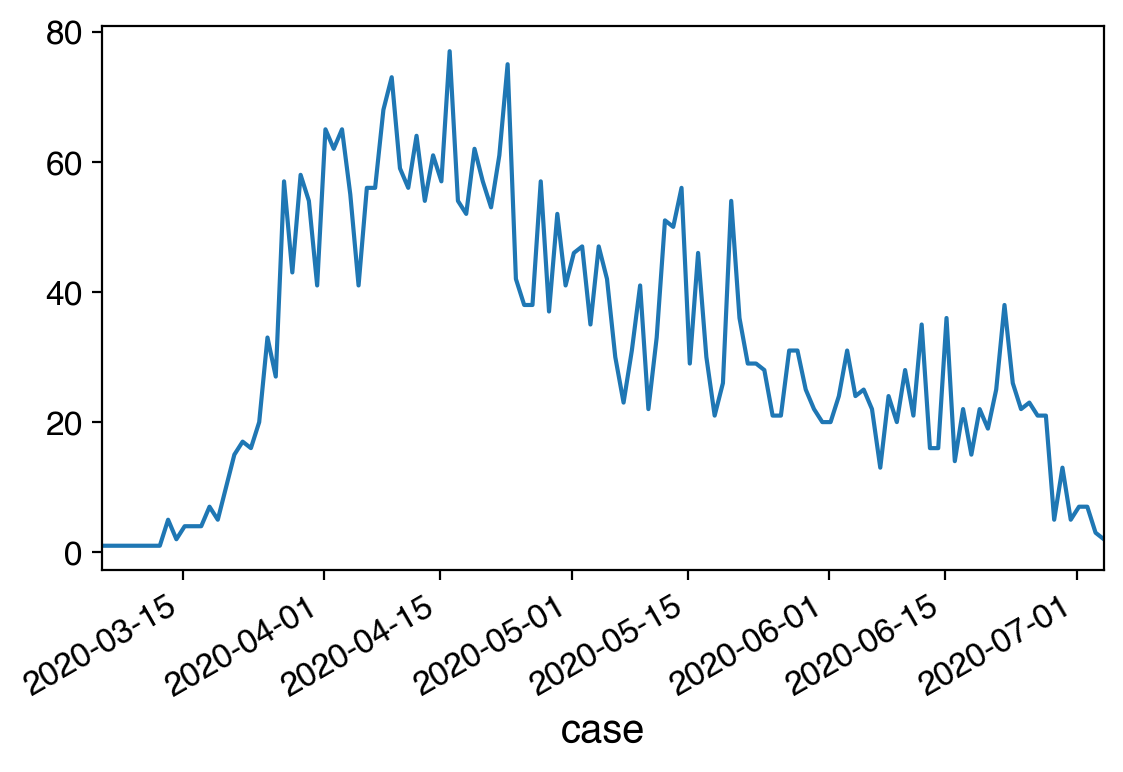

In [9]:
# dfc.groupby("case")["gender"].count().plot()
dfc.query("died").groupby("case")["gender"].count().plot()
# dfc.groupby("eventdate")["gender"].count().plot()

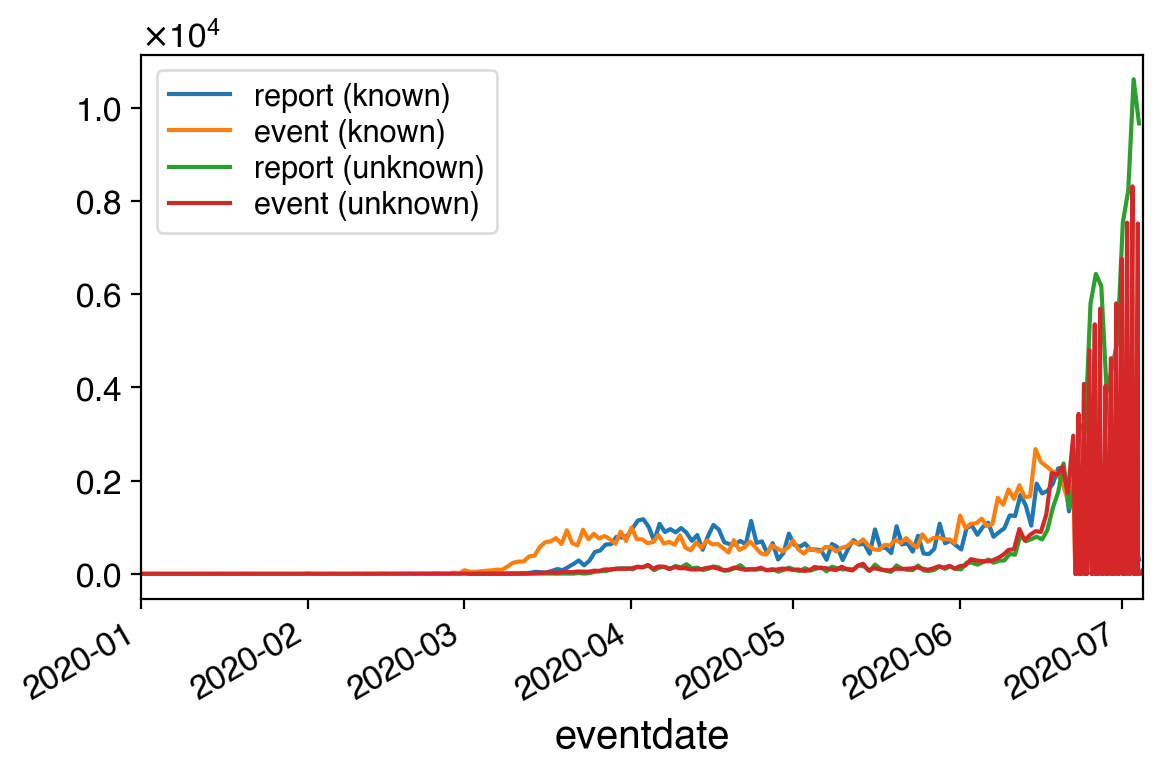

In [10]:
df = dfc.query("known_status")
df.groupby("case")["gender"].count().plot(label="report (known)")
df.groupby("eventdate")["gender"].count().plot(label="event (known)")

df = dfc.query("not known_status")
df.groupby("case")["gender"].count().plot(label="report (unknown)")
df.groupby("eventdate")["gender"].count().plot(label="event (unknown)")

plt.gca().legend()

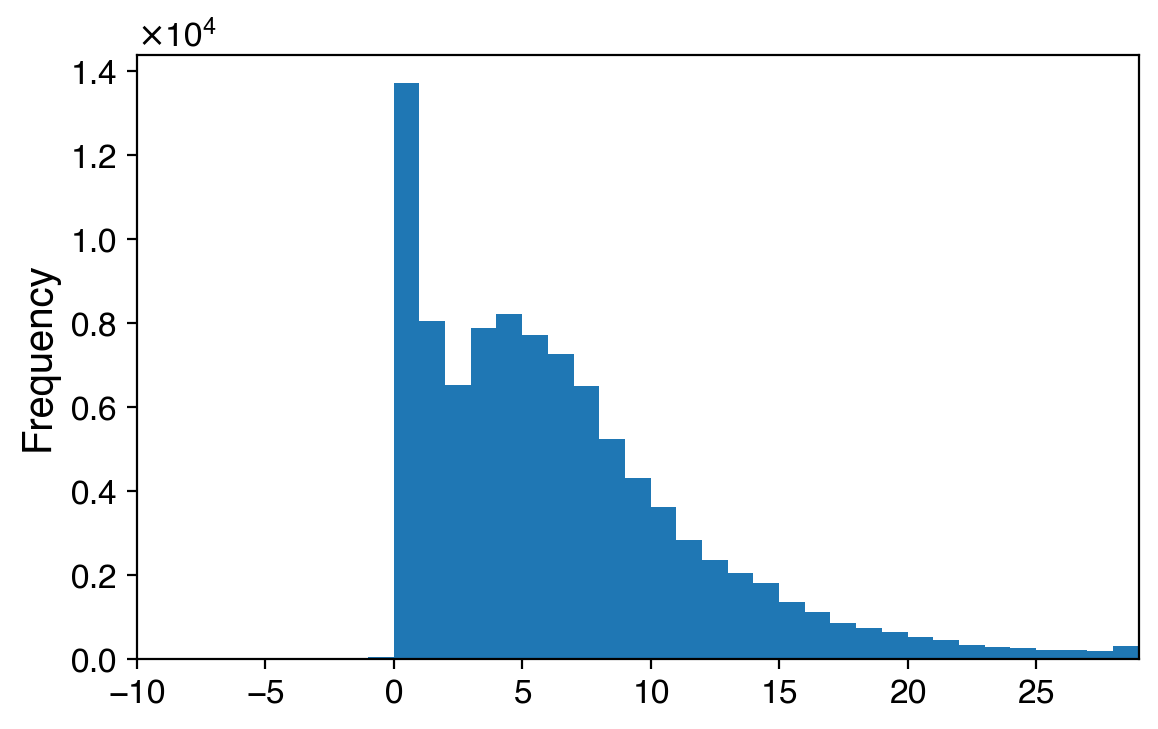

In [11]:
df = dfc.query("not died and known_status")
((df["case"]-df["eventdate"]).dt.days).plot.hist(bins=np.arange(-10,30))

In [12]:
dfc["age"].astype(int)

0         24
1         46
2         31
3         53
4         24
          ..
200106    61
200107    19
200108    19
200109    11
200110    59
Name: age, Length: 199036, dtype: int64

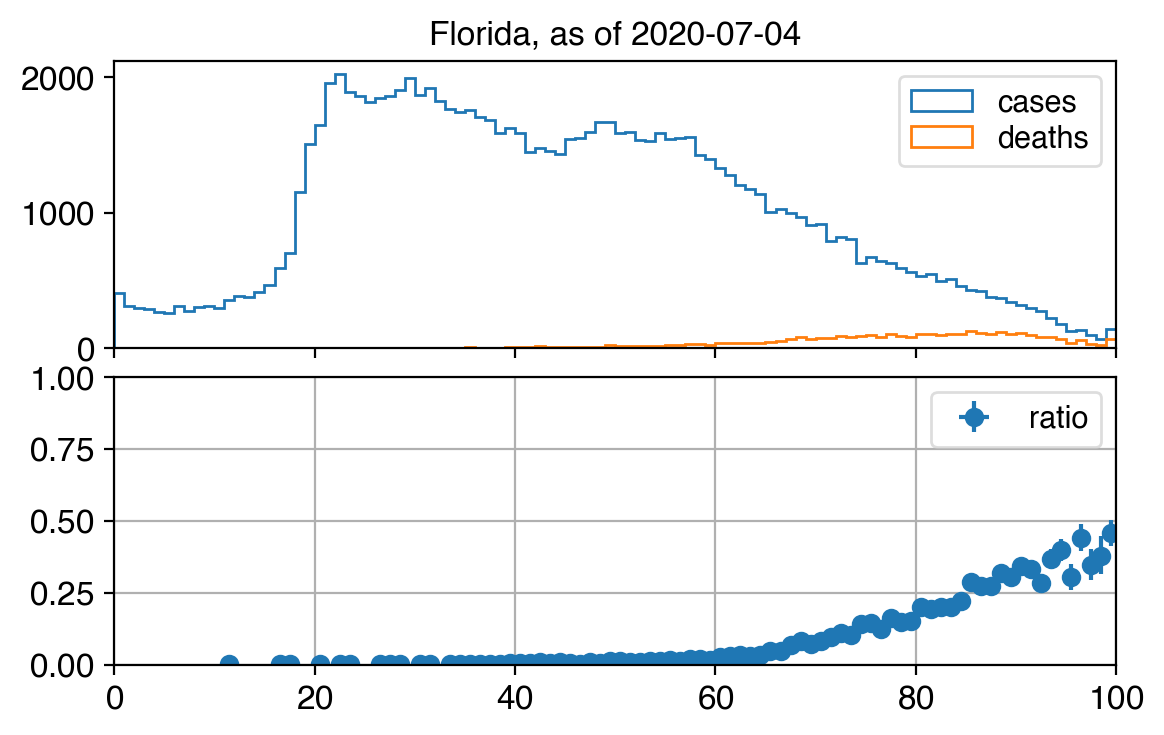

In [13]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True)

bins = "100,0,100"

# dfnumer = dfc.query("died")
dfnumer = dfc.query("died and known_status")
dfdenom = dfc.query("known_status")

hnumer = Hist1D(dfnumer["age"],bins=bins)
hdenom = Hist1D(dfdenom["age"],bins=bins)

hdenom.plot(ax=ax1, label="cases", histtype="step")
hnumer.plot(ax=ax1, label="deaths", histtype="step")

# ax1.set_yscale("log")

hratio = hnumer.divide(hdenom,binomial=True)
hratio.plot(ax=ax2, show_errors=True, label="ratio")

ax1.set_title(f"Florida, as of {str(dfc['case'].max()).split()[0]}")
ax2.set_ylim(bottom=0.,top=1.)
ax1.legend()
ax2.legend()
ax2.grid()

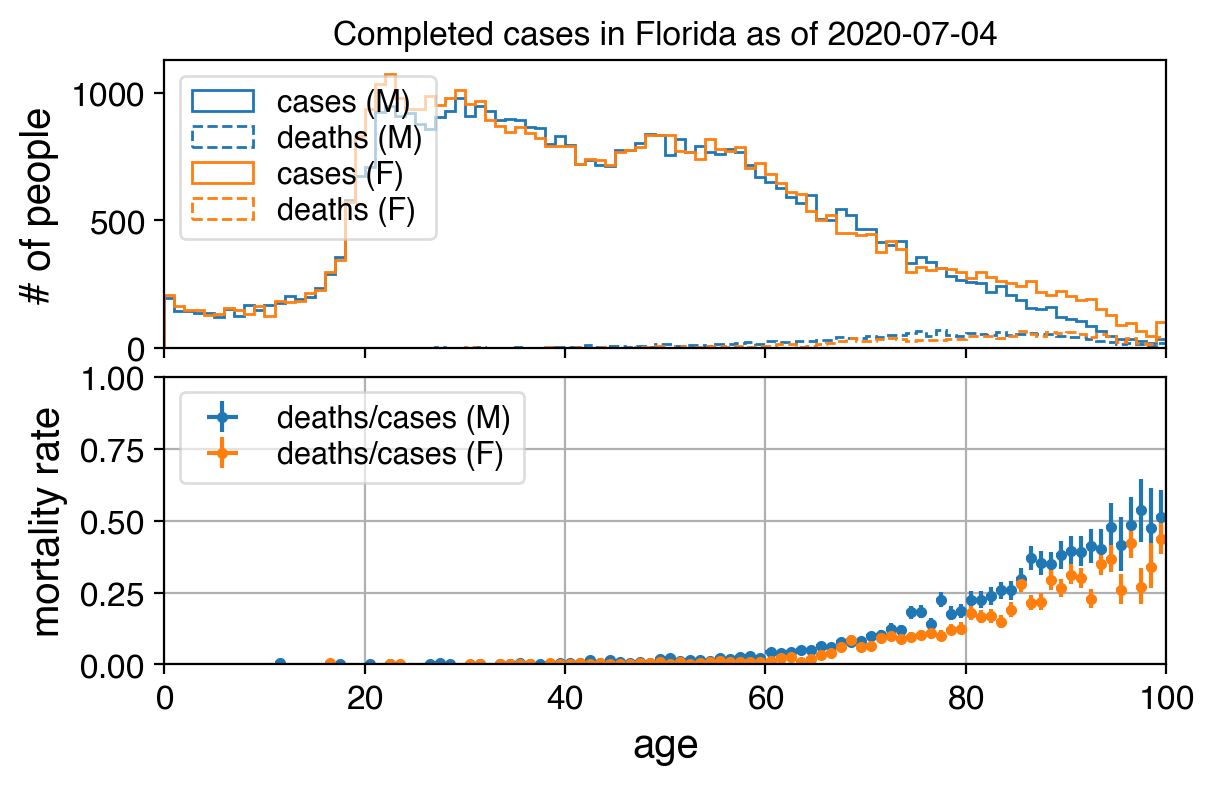

In [14]:

fig, (ax1,ax2) = plt.subplots(2,sharex=True)

def hists_gender(gender, bins="100,0,100", known=True):
    if gender in ["M","F"]:
        selstr = f"gender=='{gender}'"
    else:
        selstr = "gender!='X'"
    if known:
        selstr += " and known_status"
    dfnumer = dfc.query(selstr + " and died")
    dfdenom = dfc.query(selstr)
    hnumer = Hist1D(dfnumer["age"],bins=bins)
    hdenom = Hist1D(dfdenom["age"],bins=bins)
    hratio = hnumer.divide(hdenom,binomial=True)
    return hnumer, hdenom, hratio

hnumer, hdenom, hratio = hists_gender("M")
hdenom.plot(ax=ax1, label="cases (M)", histtype="step", color="C0")
hnumer.plot(ax=ax1, label="deaths (M)", histtype="step", color="C0", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (M)", color="C0", ms=3)

hnumer, hdenom, hratio = hists_gender("F")
hdenom.plot(ax=ax1, label="cases (F)", histtype="step", color="C1")
hnumer.plot(ax=ax1, label="deaths (F)", histtype="step", color="C1", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (F)", color="C1", ms=3)

# hnumer, hdenom, hratio = hists_gender("M", known=False)
# hdenom.plot(ax=ax1, label="cases (M), all", histtype="step", color="C2")
# hnumer.plot(ax=ax1, label="deaths (M), all", histtype="step", color="C2", linestyle="--")
# hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (M), all", color="C2", ms=3)

# hnumer, hdenom, hratio = hists_gender("F", known=False)
# hdenom.plot(ax=ax1, label="cases (F), all", histtype="step", color="C3")
# hnumer.plot(ax=ax1, label="deaths (F), all", histtype="step", color="C3", linestyle="--")
# hratio.plot(ax=ax2, show_errors=True, label="deaths/cases (F), all", color="C3", ms=3)


last = str(dfc['case'].max()).split()[0]
ax1.set_title(f"Completed cases in Florida as of {last}")
# ax1.set_yscale("log")
ax1.legend(loc="upper left")
ax1.set_ylabel("# of people")

ax2.legend(loc="upper left")
ax2.set_ylabel("mortality rate")
ax2.set_ylim(bottom=0.,top=1.0)
ax2.set_xlabel("age")
ax2.grid()

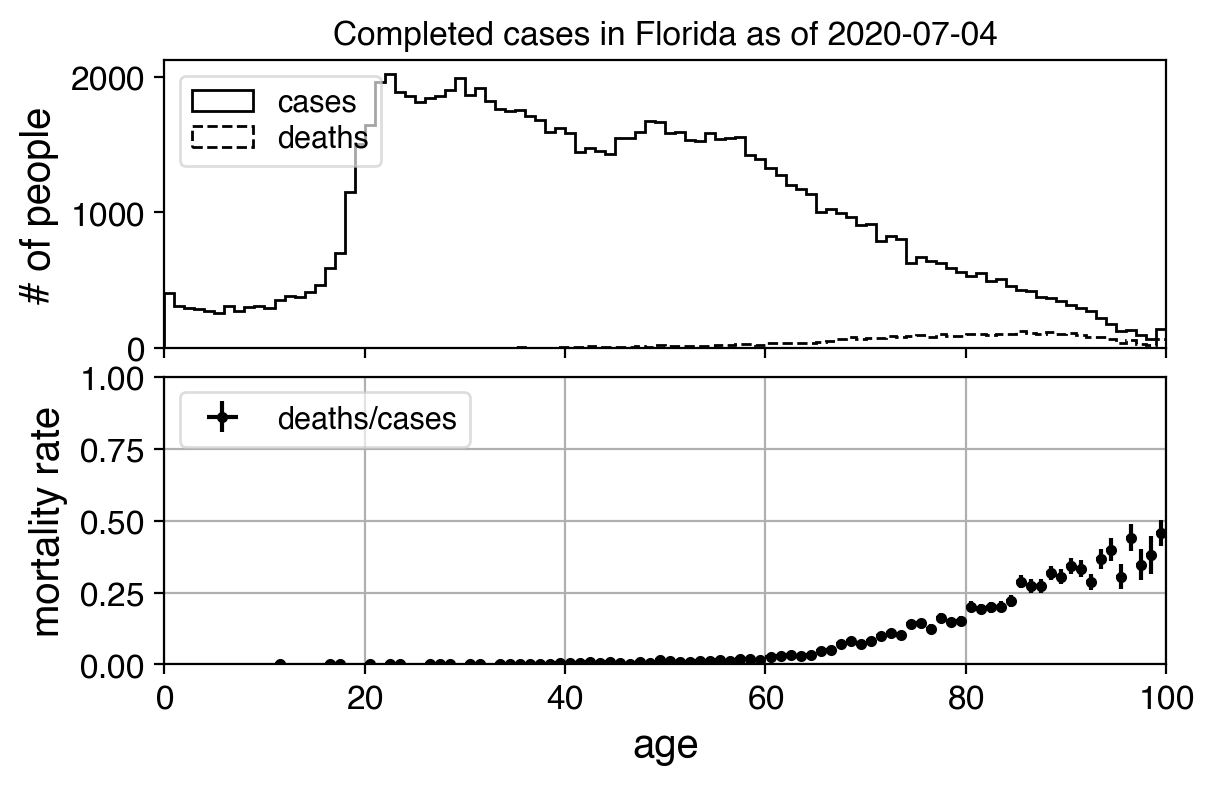

In [15]:
fig, (ax1,ax2) = plt.subplots(2,sharex=True)

hnumer, hdenom, hratio = hists_gender("X", bins="100,0,100")
hdenom.plot(ax=ax1, label="cases", histtype="step", color="k")
hnumer.plot(ax=ax1, label="deaths", histtype="step", color="k", linestyle="--")
hratio.plot(ax=ax2, show_errors=True, label="deaths/cases", color="k", ms=3)

last = str(dfc['case'].max()).split()[0]
ax1.set_title(f"Completed cases in Florida as of {last}")
# ax1.set_yscale("log")
ax1.legend(loc="upper left")
ax1.set_ylabel("# of people")

ax2.legend(loc="upper left")
ax2.set_ylabel("mortality rate")
ax2.set_ylim(bottom=0.,top=1.0)
ax2.set_xlabel("age")
ax2.grid()

In [16]:
(hnumer.counts * hnumer.bin_centers).sum() / hnumer.counts.sum()

77.85050651230101

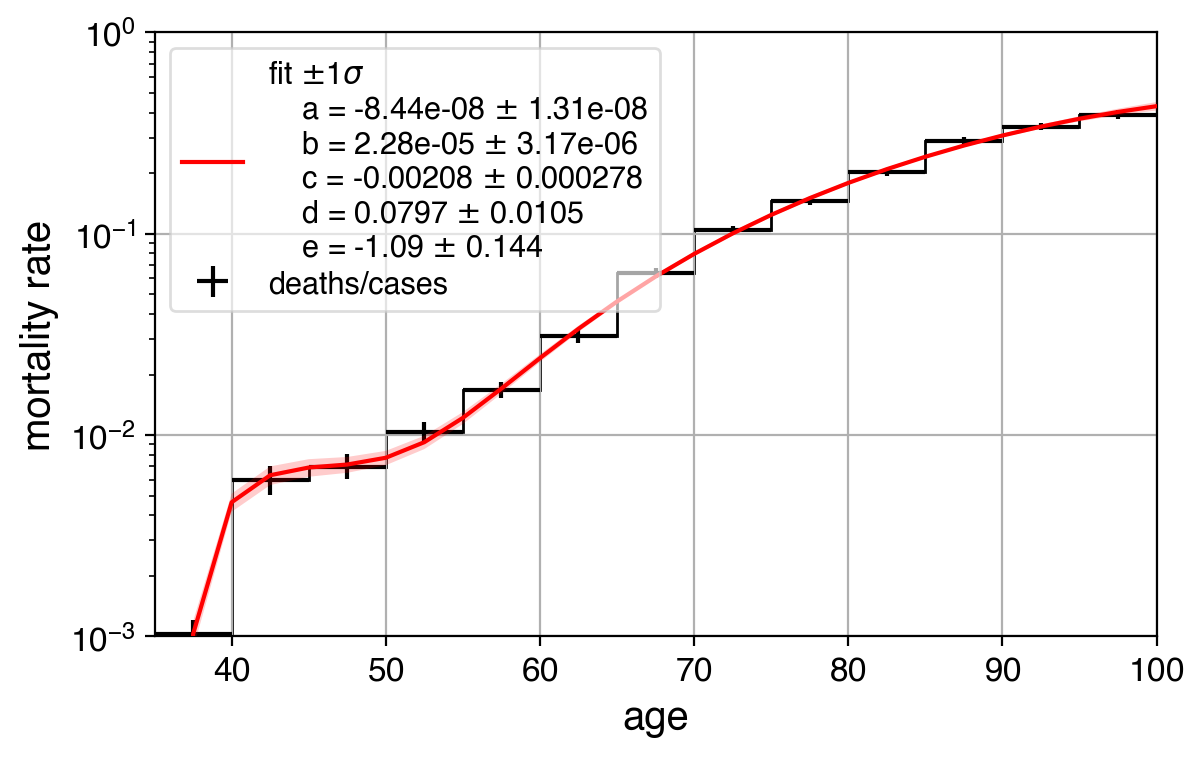

In [17]:
fig, ax = plt.subplots()

hratio = hists_gender("X",bins=np.linspace(35,100,14))[-1]
hratio.plot(ax=ax, color="k", histtype="step")
hratio.plot(ax=ax, show_errors=True, label="deaths/cases", color="k", ms=0)

func = "np.poly1d([a,b,c,d,e])(x)"
res = hratio.fit(func)

ax.legend(loc="upper left")
ax.set_ylabel("mortality rate")
ax.set_ylim(bottom=0.001,top=1.0)
ax.set_yscale("log")
ax.set_xlabel("age")
ax.grid()

In [18]:
# np.poly([1,2,3])
from yahist.utils import expr_to_lambda
# df_cfr = pd.DataFrame()
# np.poly1d([a,b,c,d,e])(x)
poly = expr_to_lambda(func)
ages = np.array([40,50,60,70,80])
cfrs = poly(ages,*res["parvalues"])
df_cfr = pd.DataFrame(dict(cfr=cfrs, age=ages))
df_cfr

,cfr,age
0,0.004640,40
1,0.007718,50
2,0.024120,60
3,0.079410,70
4,0.178890,80


Text(0.5, 1.0, 'Florida cases getting younger')

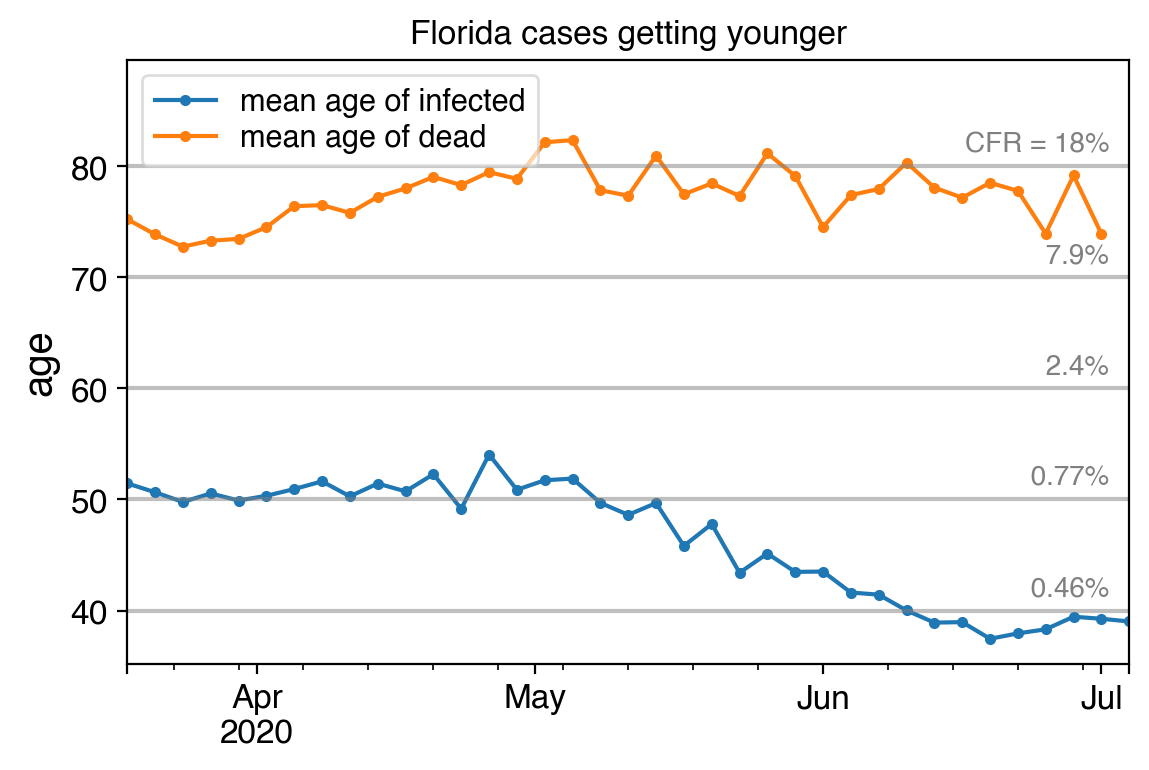

In [55]:
fig, ax = plt.subplots()
interval = "3d"
df = dfc.set_index("case").sort_index()["Mar 18, 2020":]

df.resample(interval)["age"].mean().plot(marker=".",label="mean age of infected")
# df.rolling(interval)["age"].mean().plot(marker=".",label="mean age of infected")

df = df.query("known_status and died")

df.resample(interval)["age"].mean().plot(marker=".",label="mean age of dead")
# df.rolling(interval)["age"].mean().plot(marker=".",label="mean age of dead")

import matplotlib.transforms as transforms
trans = transforms.blended_transform_factory(ax.transAxes, ax.transData)
for i,row in df_cfr.iterrows():
    cfr = row["cfr"]*100.
    age = row["age"]
    ax.axhline(age, color="gray", alpha=0.5)
    text = "CFR = {:.2g}%".format(cfr)
    if i != len(df_cfr)-1: text = text.replace("CFR =", "")
    ax.text(0.98, age+2.0, text, color="gray", transform=trans, va="center", ha="right", fontsize=10)
ax.set_ylim([None, ax.get_ylim()[1]+5.])
ax.set_xlabel("")
ax.legend()
ax.set_ylabel("age")
ax.set_title("Florida cases getting younger")

Text(0.5, 0, 'age')

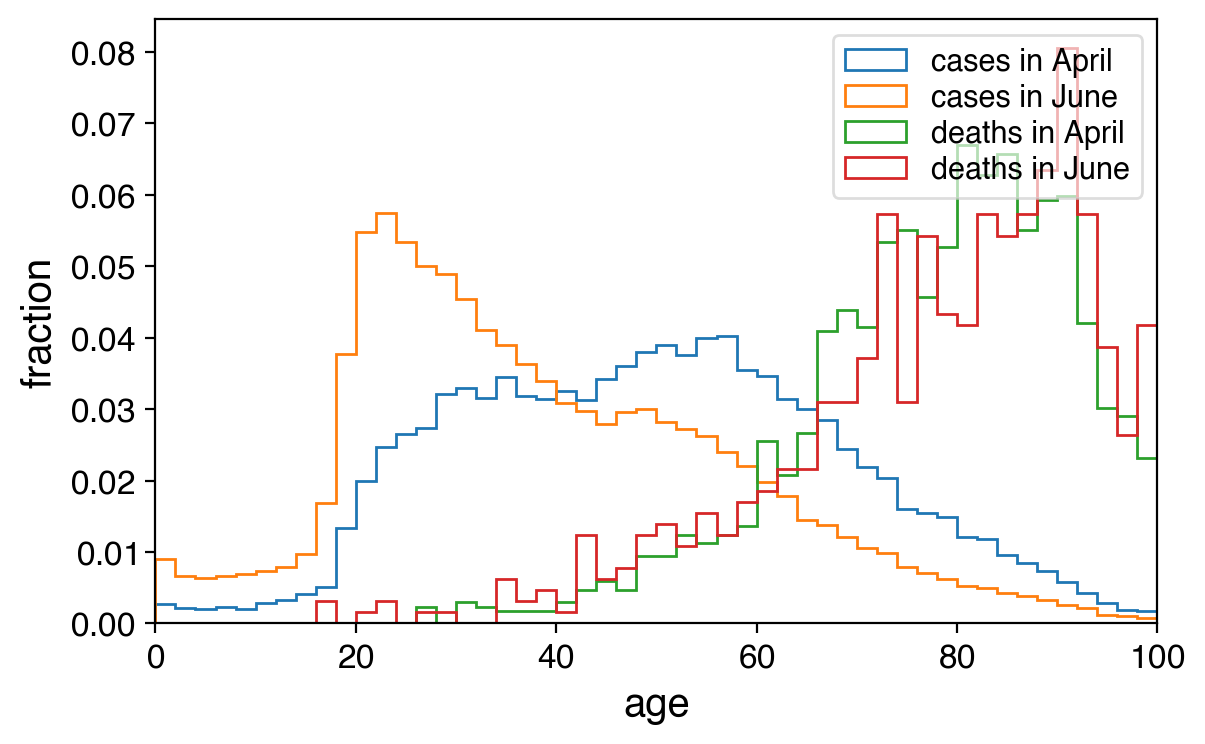

In [25]:
bins = "50,0,100"
df = dfc.set_index("case")
h1 = Hist1D(df["Apr 1, 2020":"Apr 30, 2020"].query("not died")["age"], bins=bins).normalize()
h2 = Hist1D(df["Jun 1, 2020":"Jun 30, 2020"].query("not died")["age"], bins=bins).normalize()
h1.plot(histtype="step", label="cases in April")
h2.plot(histtype="step", label="cases in June")

h1 = Hist1D(df["Apr 1, 2020":"Apr 30, 2020"].query("died")["age"], bins=bins).normalize()
h2 = Hist1D(df["Jun 1, 2020":"Jun 30, 2020"].query("died")["age"], bins=bins).normalize()
h1.plot(histtype="step", label="deaths in April")
h2.plot(histtype="step", label="deaths in June")

plt.gca().set_ylabel("fraction")
plt.gca().set_xlabel("age")

In [32]:

dfc.set_index("case").sort_index()["Feb 21, 2020":]

,age,died,eventdate,gender,hospitalized,known_status
case,,,,,,
2020-03-02 05:00:00,29,False,2020-02-22,F,NO,True
2020-03-02 05:00:00,63,False,2020-02-22,M,YES,True
2020-03-03 05:00:00,22,False,2020-02-25,F,NO,True
2020-03-03 05:00:00,54,False,2020-02-02,M,UNKNOWN,False
2020-03-04 05:00:00,59,False,2020-02-15,F,YES,True
...,...,...,...,...,...,...
2020-07-04 05:00:00,25,False,2020-07-04,M,UNKNOWN,False
2020-07-04 05:00:00,55,False,2020-07-04,F,UNKNOWN,False
2020-07-04 05:00:00,23,False,2020-07-04,M,UNKNOWN,False
